In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

A simple environment to create the images.  Since the goal is something like Pong, I figured making an environment that looks like the Pong game would be good.

In [199]:
class Environment:
    def __init__(self):
        self.image = np.zeros((80, 120))
        self.pos = np.array([40, 60], dtype=float)
        self.vel = np.array([20, 25], dtype=float)
        
    def update(self, dt=0.001):
        self.pos += self.vel*dt
        if self.pos[0] >= self.image.shape[0]:
            self.pos[0] = self.image.shape[0]-1 - (self.pos[0] - self.image.shape[0])
            self.vel[0] *= -1
        if self.pos[1] >= self.image.shape[1]:
            self.pos[1] = self.image.shape[1]-1 - (self.pos[1] - self.image.shape[1])
            self.vel[1] *= -1
        if self.pos[0] < 0:
            self.pos[0] = - self.pos[0]
            self.vel[0] *= -1
        if self.pos[1] < 0:
            self.pos[1] = - self.pos[1]
            self.vel[1] *= -1
            
        self.image[:,:] = 0
        r = 2
        for x in range(int(self.pos[0])-r, int(self.pos[0])+r):
            for y in range(int(self.pos[1])-r, int(self.pos[1])+r):
                self.image[x,y] = 1
        
        self.image[45:55, 10:12] = 1
        self.image[25:35, 108:110] = 1


env = Environment()
for i in range(300):    # run the simulation a little bit just to get some movement
    env.update()

img = env.image

Now let's look at the raw image.

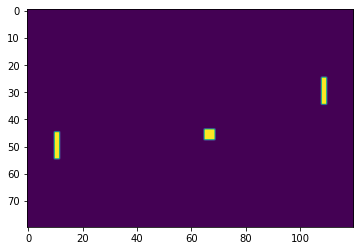

In [200]:
plt.imshow(img)

We want to convert this image into a semantic pointer representation.  Each pixel has a particular semantic pointer ($X^x*Y^y$, where $*$ is circular convolution and the exponent is exponential circular convolution).  So, the simplest way to convert an image is just to make a big giant matrix of the SSPs for each pixel and just multiply the image by that matrix.

There are two free parameters here: the dimensionality of the $X$ and $Y$ vectors, and the scaling factor applied to the $x$ and $y$ values.  The scaling factor affects how blurry the representation is ($X^x$ and $X^{x+1}$ are very dissimilar vectors, but $X^x$ and $X^{x+0.1}$ are very similar). 

The $X$ and $Y$ vectors need to be randomly chosen unitary vectors, so I'm using `nengo_spa` to generate them.  You may need to install that with `pip install nengo_spa`.

In [201]:
def power(s, e):
    return np.fft.ifft(np.fft.fft(s) ** e).real
def circonv(s1, s2):
    return np.fft.ifft(np.fft.fft(s1) * np.fft.fft(s2)).real

D = 512
import nengo_spa as spa
vocab = spa.Vocabulary(D)
vocab.populate('X.unitary()')
vocab.populate('Y.unitary()')
X = vocab.parse('X').v
Y = vocab.parse('Y').v

m = np.zeros((D, img.shape[0]*img.shape[1]))

scale = 0.3

for j in range(img.shape[0]):
    for i in range(img.shape[1]):
        ssp = circonv(power(X, scale*i), power(Y, scale*j))
        m[:,j*img.shape[1]+i] = ssp

Now that we have our matrix, we can take an image and project it into the SSP space just by mutiplying it by m.  We also normalize it here, just because when we eventually put it into neurons, we'll need to make sure that the vector is not too large.

In [204]:
S = m.dot(img.flatten())
S = S / np.linalg.norm(S)

We now have a D-dimensional vector representing our image, so we've clearly lost information somewhere.  So let's see what we can do to recover the image.  The simplest thing we can do here is just project it back, either by using the transpose of the m matrix, or its inverse.  For simplicity, let's just use the transpose.

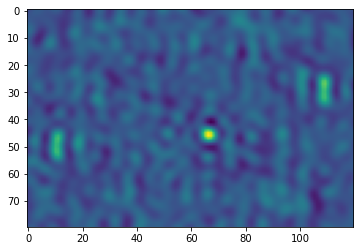

In [213]:
plt.imshow(m.T.dot(S).reshape((80,120)))

As we adjust D and scale, the accuracy of this recreation will be affected.

Now that we have this, let's try feeding the input into a nengo model.

In [214]:
env = Environment()

model = nengo.Network()
with model:
    def stim_func(t):
        env.update()
        img = env.image
        S = m.dot(img.flatten())
        S = S / np.linalg.norm(S)
        return S 
    stim = nengo.Node(stim_func)
    ens = nengo.Ensemble(n_neurons=3000, dimensions=D,
                         )
    nengo.Connection(stim, ens)
    
    p = nengo.Probe(ens, synapse=0.1)
sim = nengo.Simulator(model)
with sim:
    sim.run(0.7)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

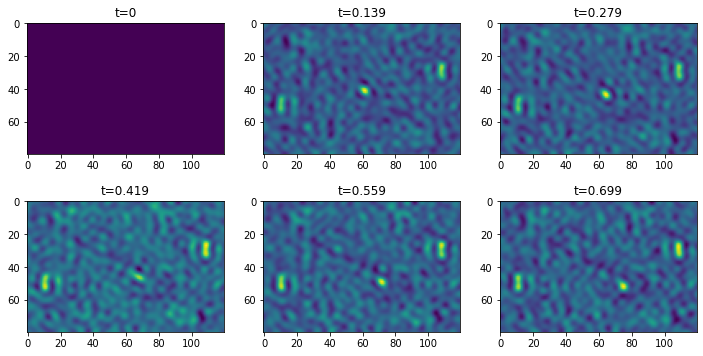

In [220]:
plt.figure(figsize=(12,6))
for i, index in enumerate(np.linspace(0, sim.n_steps-1, 6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(m.T.dot(sim.data[p][int(index)]).reshape((80,120)))
    plt.title('t=%g' %(int(index)*sim.dt))